# Simulating randomized benchmarking

In this example, we will reproduce a randomized benchmarking experiment used in Figure 3a of [Piltz et. al.](https://www.nature.com/articles/ncomms5679?origin=ppub)

Note: This example is quite computationally expensivem, hence for the full simulation we use [joblib](https://joblib.readthedocs.io/en/latest/) for parallel computing. However, you don't need this to run the demo.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip_qip
from qutip import (Qobj, SolverOptions, basis, fock_dm, qeye, sigmax, sigmay,
                   sigmaz, tensor)
from qutip.ipynbtools import version_table
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor
from qutip_qip.noise import Noise
from qutip_qip.operations import Gate
from scipy.optimize import curve_fit

We build a two-qubit Processor, where the second qubit is detuned from the first one by $\delta= 1.852$MHz. A sequence of $\pi$-pulses with Rabi frequency of $\Omega= 20$KHz and random phases are applied to the first qubit. We define noise such that the same pulse also applies to the second qubit. Because of the detuning, this pulse does not flip the second qubit but subjects it to a diffusive behaviour, so that the average fidelity of the second qubit with respect to the initial state decreases.

Here, we reproduce these results with a two-qubit `Processor`.
We start with an initial state of fidelity 0.975 and simulate the Hamiltonian
\begin{align}
H=\Omega(t)(\sigma^x_0 + \lambda \sigma^x_1) + \delta\sigma^z_1
,
\end{align}
where $\lambda$ is the ratio between the cross-talk pulse's amplitudes.

In the cell below, we first build a Hamiltonian model called `MyModel`.
For simplicity, we only include two single-qubit control Hamiltonians: $\sigma_x$ and $\sigma_y$.
We then define the compiling routines for the two types of rotation gates RX and RY.
In addition, we also define a rotation gate with mixed X and Y quadrature, parameterized by a phase $\phi$, $\cos(\phi)\sigma_x+\sin(\phi)\sigma_y$.
This will be used later in the example of custom noise.

We then initialize a `ModelProcessor` with this model.
In the `ModelProcessor`, the default simulation workflow is already defined, such as the `load_circuit` method.
Since rotations around the $x$ and $y$ axes are the native gates of our hardware, we define them in the attribute \texttt{native\_gates}.
Providing this native gates set, rotation around $z$ axis will be automatically decomposed into rotations around $x$ and $y$ axes.
We define a circuit consisting of $\pi/2$ rotation followed by a Z gate.
The compiled pulses are shown in \cref{fig:customize pulse}, where the Z gate is decomposed into rotations around $x$ and $y$ axes.

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


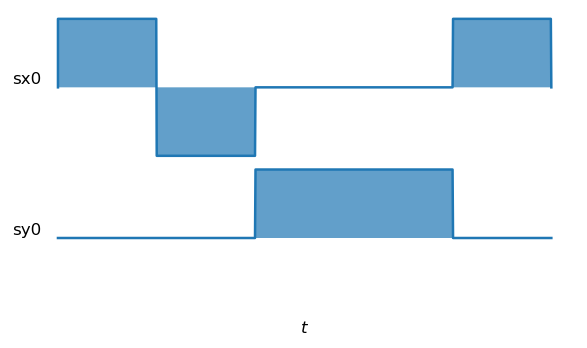

In [2]:
class MyModel(Model):
    """A custom Hamiltonian model with sigmax and sigmay control."""

    def get_control(self, label):
        """
        Get an available control Hamiltonian.
        For instance, sigmax control on the zeroth
        qubits is labeled "sx0".

        Args:
            label (str): The label of the Hamiltonian

        Returns:
            The Hamiltonian and target qubits as a tuple
            (qutip.Qobj, list).
        """
        targets = int(label[2:])
        if label[:2] == "sx":
            return 2 * np.pi * sigmax() / 2, [targets]
        elif label[:2] == "sy":
            return 2 * np.pi * sigmay() / 2, [targets]
        else:
            raise NotImplementedError("Unknown control.")


class MyCompiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "ROT": self.rotation_with_phase_compiler,
            "RX": self.single_qubit_gate_compiler,
            "RY": self.single_qubit_gate_compiler,
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
            ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        tlist = np.abs(gate.arg_value) / self.params["pulse_amplitude"]
        coeff = self.params["pulse_amplitude"] * np.sign(gate.arg_value)
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist, coeff, phase=0.0)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist, coeff, phase=np.pi / 2)

    def rotation_with_phase_compiler(self, gate, args):
        """Compiles gates with a phase term.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the pulse phase
        tlist = self.params["duration"]
        coeff = self.params["pulse_amplitude"]
        return self.generate_pulse(gate, tlist, coeff, phase=gate.arg_value)


# Define a circuit and run the simulation
num_qubits = 1

circuit = QubitCircuit(1)
circuit.add_gate("RX", targets=0, arg_value=np.pi / 2)
circuit.add_gate("Z", targets=0)

myprocessor = ModelProcessor(model=MyModel(num_qubits))
myprocessor.native_gates = ["RX", "RY"]

mycompiler = MyCompiler(num_qubits, {"pulse_amplitude": 0.02})

myprocessor.load_circuit(circuit, compiler=mycompiler)
result = myprocessor.run_state(basis(2, 0))

fig, ax = myprocessor.plot_pulses(figsize=(5, 3), dpi=120,
                                  use_control_latex=False)
ax[-1].set_xlabel("$t$")
fig.tight_layout()

We now define a custom `ClassicalCrossTalk` noise object that uses the `Noise` class as the base.
The `get_noisy_dynamics` method will be called during the simulation to generate the noisy Hamiltonian model.
Here, we define a noise model that adds the same driving Hamiltonian to its neighbouring qubits, with a strength proportional to the control pulses strength applied on it.
The detuning of the qubit transition frequency is simulated by adding a $\sigma_z$ drift Hamiltonian to the processor, with a frequency of $1.852$ MHz.




In [3]:
class ClassicalCrossTalk(Noise):
    def __init__(self, ratio):
        self.ratio = ratio

    def get_noisy_dynamics(self, dims=None, pulses=None,
                           systematic_noise=None):
        """Adds noise to the control pulses.

        Args:
            dims: Dimension of the system, e.g., [2,2,2,...] for qubits.
            pulses: A list of Pulse objects, representing the compiled pulses.
            systematic_noise: A Pulse object with no ideal control,
            used to represent pulse-independent noise such as decoherence
            (not used in this example).
        Returns:
            pulses: The list of modified pulses according to the noise model.
            systematic_noise: A Pulse object (not used in this example).
        """
        for i, pulse in enumerate(pulses):
            if "sx" not in pulse.label and "sy" not in pulse.label:
                continue  # filter out other pulses, e.g. drift
            target = pulse.targets[0]
            if target != 0:  # add pulse to the left neighbour
                pulses[i].add_control_noise(
                    self.ratio * pulse.qobj,
                    targets=[target - 1],
                    coeff=pulse.coeff,
                    tlist=pulse.tlist,
                )
            if target != len(dims) - 1:  # add pulse to the right neighbour
                pulses[i].add_control_noise(
                    self.ratio * pulse.qobj,
                    targets=[target + 1],
                    coeff=pulse.coeff,
                    tlist=pulse.tlist,
                )
        return pulses, systematic_noise

Lastly, we define a random circuit consisting of a sequence of $\pi$ rotation pulses with random phases.
The driving pulse is a $\pi$ pulse with a duration of $25 \, \mu\rm{s}$ and Rabi frequency $20$ KHz.
This randomized benchmarking protocol allows one to study the classical cross-talk induced decoherence on the neighbouring qubits.
The two qubits are initialized in the $|00\rangle$ state with a fidelity of 0.975.
After the circuit, we measure the population of the second qubit.
If there is no cross-talk, it will remain perfectly in the ground state.
However, cross-talk induces a diffusive behaviour of the second qubit and the fidelity decreases.

This simulation is repeated 1600 times to obtain the average fidelity. This may take several hours, therefore, the following code only takes two samples with $t=250$. The full simulation is in the commented lines.

In [4]:
def single_crosstalk_simulation(num_gates):
    """
    A single simulation, with num_gates representing the number of rotations.

    Args:
        num_gates (int): The number of random gates to add in the simulation.

    Returns:
        result (qutip.solver.Result):
            A qutip Result object obtained from any of the
            solver methods such as mesolve.
    """
    # Qubit-0 is the target qubit. Qubit-1 suffers from crosstalk.
    num_qubits = 2
    myprocessor = ModelProcessor(model=MyModel(num_qubits))
    # Add qubit frequency detuning 1.852MHz for the second qubit.
    myprocessor.add_drift(2 * np.pi * (sigmaz() + 1) / 2 * 1.852, targets=1)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = MyCompiler(num_qubits,
                            {"pulse_amplitude": 0.02, "duration": 25})
    myprocessor.add_noise(ClassicalCrossTalk(1.0))
    # Define a randome circuit.
    gates_set = [
        Gate("ROT", 0, arg_value=0),
        Gate("ROT", 0, arg_value=np.pi / 2),
        Gate("ROT", 0, arg_value=np.pi),
        Gate("ROT", 0, arg_value=np.pi / 2 * 3),
    ]
    circuit = QubitCircuit(num_qubits)
    for ind in np.random.randint(0, 4, num_gates):
        circuit.add_gate(gates_set[ind])
    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    init_state = tensor(
        [Qobj([[init_fid, 0], [0, 0.025]]),
         Qobj([[init_fid, 0], [0, 0.025]])]
    )
    # increase the maximal allowed steps
    options = SolverOptions(nsteps=10000)
    e_ops = [tensor([qeye(2), fock_dm(2)])]  # observable

    # compute results of the run using a solver of choice
    result = myprocessor.run_state(
        init_state, solver="mesolve", options=options, e_ops=e_ops
    )
    # measured expectation value at the end
    result = result.expect[0][-1]
    return result


# The full simulation may take several hours
# so we just choose num_sample=2 and num_gates=250 as a test
num_sample = 2
fidelity = []
fidelity_error = []
init_fid = 0.975
num_gates_list = [250]

# The full simulation is defined in the commented lines below.

# from joblib import Parallel, delayed  # for parallel simulations
# num_sample = 1600
# num_gates_list = [250, 500, 750, 1000, 1250, 1500]

for num_gates in num_gates_list:
    expect = [single_crosstalk_simulation(num_gates)
              for i in range(num_sample)]
    fidelity.append(np.mean(expect))
    fidelity_error.append(np.std(expect) / np.sqrt(num_sample))

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/options.py:7: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


We plot a recorded result as an illustration.

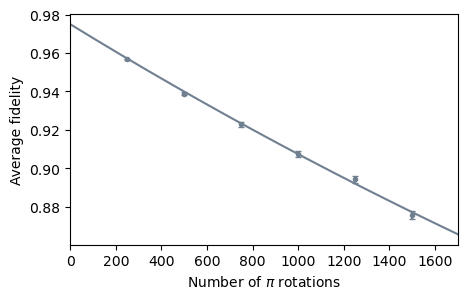

In [5]:
# Recorded result of a full simulation
num_gates_list = [250, 500, 750, 1000, 1250, 1500]
fidelity = [
    0.9566768747558925,
    0.9388905075892828,
    0.9229470389282218,
    0.9075513000339529,
    0.8941659320508855,
    0.8756519016627652,
]

fidelity_error = [
    0.00042992029265330223,
    0.0008339882813741004,
    0.0012606632769758602,
    0.0014643550337816722,
    0.0017695604671714809,
    0.0020964978542167617,
]


def rb_curve(x, a):
    return (1 / 2 + np.exp(-2 * a * x) / 2) * 0.975


pos, cov = curve_fit(rb_curve, num_gates_list, fidelity, p0=[0.001])

xline = np.linspace(0, 1700, 200)
yline = rb_curve(xline, *pos)

fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
ax.errorbar(
    num_gates_list, fidelity, yerr=fidelity_error, fmt=".",
    capsize=2, color="slategrey"
)
ax.plot(xline, yline, color="slategrey")
ax.set_ylabel("Average fidelity")
ax.set_xlabel(r"Number of $\pi$ rotations")
ax.set_xlim((0, 1700));

In [6]:
print("qutip-qip version:", qutip_qip.version.version)
version_table()

qutip-qip version: 0.5.0.dev0+d58a82d


Software,Version
QuTiP,5.2.0.dev0+4033695
Numpy,2.2.4
SciPy,1.15.2
matplotlib,3.10.1
Number of CPUs,4
BLAS Info,Generic
IPython,9.1.0
Python,"3.12.0 | packaged by conda-forge | (main, Oct 3 2023, 08:43:22) [GCC 12.3.0]"
OS,posix [linux]
Cython,3.0.12
